# Dart Throwing Simulation and Optimization

My buddies and I play a good amount of darts. In the beginning we all sucked. Slowly we have been getting better. As I get better, I want to know where the optimal place to aim the dart for my skill level. This notebook investigates that question.

$\\$


$\\$

Import necessary libraries.

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib
import scipy.misc
import scipy.ndimage.filters
import pandas as pd
import seaborn as sns
from __future__ import division
%matplotlib inline

C:\Users\TJ\Anaconda\lib\site-packages\matplotlib\__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


$\\$


$\\$

Define classes for dartboard, dart, and thrower. The dartboard class will hold all global information about the dartboard. The thrower is modeled as a random distrubtion, the aiming location is the x,y pixel coordinates on the dartboard image, and the standard deviation is the skill level. The dart class will hold the location of the dart, and have a method for calculating the score of the dart.

Strategy for scoring the dart:

- Calculate distance from center to dart
- Check if dart is on the board, if not return 0 
- Check if the dart is in bulls eye or double bulls eye, if so return 25 or 50
- Find the angle from the 13-6 line to the dart location using the center location as origin. Since we are finding the angle by inverse cosine, negative angles and positive angles will be the same, thus we also need to find if the dart is above or below to 13-6 line. 
- Since the angle will be from 0 to $\pi$ radians, dividing from $\pi$ randians will transform the angle into a fraction of the 180 degrees. Multiplying by the number of slices in each hemisphere and taking the floor function returns how many slices away from the horizion the dart is located.
- Check if the dart is in range of a double or triple muliplier. 

In [2]:
# useful function
def distance(loc1, loc2):
    return math.hypot(loc2[0] - loc1[0], loc2[1] - loc1[1])

class Dartboard: 
    '''Static class which holds information of dartboard'''
    
    # Holds image
    image = scipy.misc.imread('dartboard.png')
    
    # Holds scores -> first list is below the 13/6 horizion, second is above it.
    # scores then organized by increasing angle away from the 13/6 line
    scores = [[6,10,15,2,17,3,19,7,16,8],[13,4,18,1,20,5,12,9,14,11]]
    
    # Holds center location, found by guess and check
    center = np.array([200,199])
    
    # Holds unit vector along 13/6 line, used as a horizion 
    horizion_point = np.array([320,179])
    horizion_line = (horizion_point - center)/distance(horizion_point, center)
    
    # Get equation of horizion line
    slope = horizion_line[1]/horizion_line[0]
    intercept = (slope * center[0] - center[1])
    
    # Get length and width of image
    length = len(image)
    width = len(image[0])
    
    # Holds distances of scored dart locations from center
    play_range = 137
    double = 128
    triple_inner = 78
    triple_outer = 85
    bulls_eye = 5
    bulls_eye_outer = 12


In [3]:
class Thrower:
    '''
        Encapulates thrower, skill modeled as standard devation of
        a normal distrubtion. 
        
        std - skill:
            60 - Beginner
            45 - Novice
            20 - Good
            5 - Super good
            
        Method: Throw n darts at an aiming location
    '''
    
    def __init__(self, std):
        self.std = std

    def throw(self, aim = Dartboard.center, n=1):
        '''throws n randomly distrubted darts at location aim '''
         
        # Holds dart throws
        darts = []

        # throw the darts according to the random distribution
        for i in range(n):
            darts.append(Dart([np.random.randn()*self.std+ aim[0], 
                          np.random.randn()*self.std+ aim[1]]))

        return darts

In [4]:
class Dart:
    '''
       Dart class, each dart has a location, distance from center and score.
       The score takes a little bit of calculation, so calculating it is held off
       unless asked for
    '''
    def __init__(self, loc):
        self.loc = np.array(loc)
        self.distance_center = distance(Dartboard.center, self.loc)

    def angle_from_horizon(self):
        '''Gets the angle in rads from 13-6 line, used to get score'''
        
        # Dart - center vector
        dart_to_center = self.loc - Dartboard.center

        # Return angle in rads from 13/6 line
        return math.acos(np.dot(dart_to_center,Dartboard.horizion_line)/(self.distance_center))

    def above_horizion(self):
        '''Shows if above or below 13-6 line'''

        # return 0 if dart is below, 1 if above
        return int(self.loc[1] <  Dartboard.slope * self.loc[0] - Dartboard.intercept)
        
    def get_multiplier(self):
        '''Gets score multiplier'''

        if self.distance_center > Dartboard.double:
            return 2
        
        if (self.distance_center > Dartboard.triple_inner) & (self.distance_center < Dartboard.triple_outer):
            return 3
        
        else:
            return 1
        
    def score_dart(self):
        '''Scores the dart location'''
        
        
        # Check if in play range, no need to do anything else        
        if self.distance_center > Dartboard.play_range:
            return 0
        
        # Check if in bulls eyes
        if self.distance_center < Dartboard.bulls_eye:
            return 50
        if self.distance_center < Dartboard.bulls_eye_outer:
            return 25

        # Check how many slices away from horizion
        nth_space = int(10* self.angle_from_horizon()/math.pi) 
        
        # return score
        return self.get_multiplier() * Dartboard.scores[self.above_horizion()][nth_space]

$\\$


$\\$

It's not obvious how skill and the standard devation translate. The graphs below show samples of standard devations of 60, 50, 40, 30, 25, 20, 15, 10 and 5.

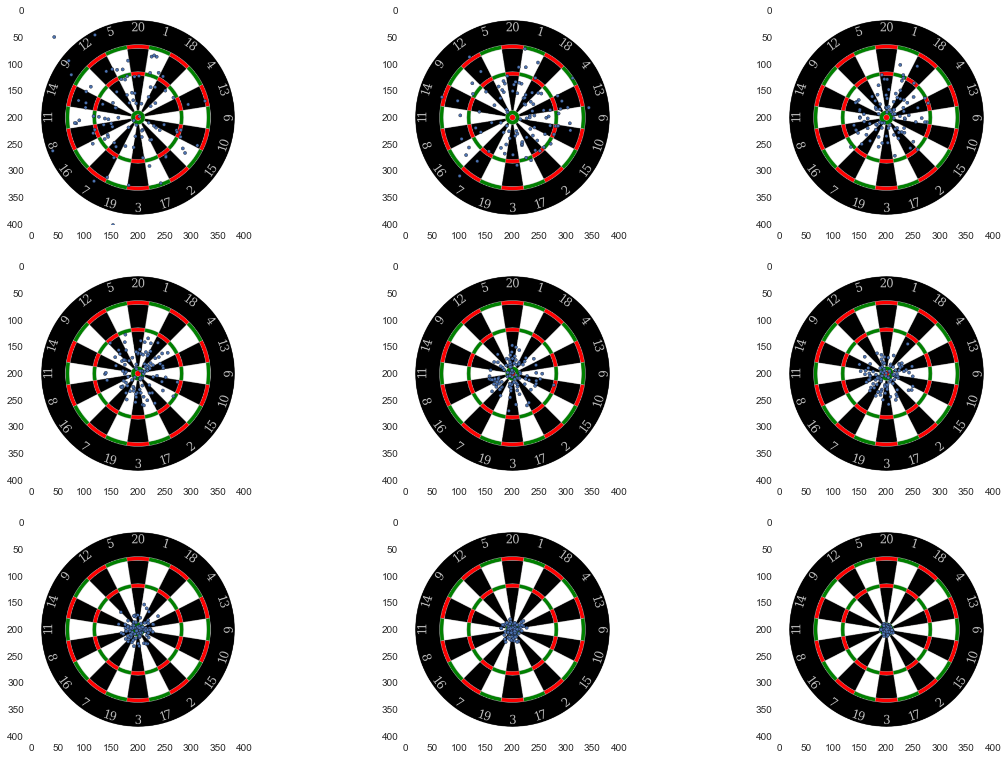

In [15]:
pic_rows, pic_columns = (3,3)
stds = [60,50,40,30,25,20,15,10,5]

fig, ax = plt.subplots(pic_rows,pic_columns, figsize=(19,13))


count = 0 
for row in range(pic_rows):
    for col in range(pic_columns):
        
        # Create thrower and throw darts
        thrower = Thrower(stds[count])
        darts = thrower.throw(n=100)

        # plot darts
        for dart in darts:
            ax[row,col].add_patch(matplotlib.patches.Circle(dart.loc, radius=3))

        ax[row,col].grid(False)
        ax[row,col].imshow(Dartboard.image)
        
        count += 1

$\\$


$\\$


$\\$


$\\$

$\\$


$\\$

$\\$

$\\$


$\\$
To see how to the expected score changes with aim location, we run a simulation throwing $n$ darts at each pixel location, then  averaging the nieghboring results using a guassain filter to smooth the results.

In [6]:
def run_simulation(std, n = 10, averaging_window = 7):
    '''
        Throws n darts at each pixel location and 
        returns matrix of score values
    '''
    
    # Make thrower object
    thrower = Thrower(std)
    
    # Holds scores for each location
    scores = []
    
    # For each pixel location
    for aim_x in range(Dartboard.width):
        for aim_y in range(Dartboard.length):
            
            # Throw n darts at location 
            darts = thrower.throw(n=n,aim = [aim_x,aim_y])
            
            # Total score for all darts
            score = 0
            for dart in darts:
                score += dart.score_dart()
                
            # Append Total score
            scores.append(score)
            
    # Reshape scores array into matrix with same dimensions dartboard
    scores = np.array(scores).reshape(Dartboard.width,Dartboard.length)
    
    # Filter image to smooth results
    scores = scipy.ndimage.filters.gaussian_filter(scores.T,averaging_window)
    
    # Returned normalized 
    return scores
    

$\\$

$\\$


$\\$


Run simulation for different skill levels. Skill increasing from 60 to 5, same vector as the sample above. See the stds vector to see actual values

In [11]:
# Run simulation for each skill level and save results in list
scores = []
for std in stds:
    scores.append(run_simulation(std)) 

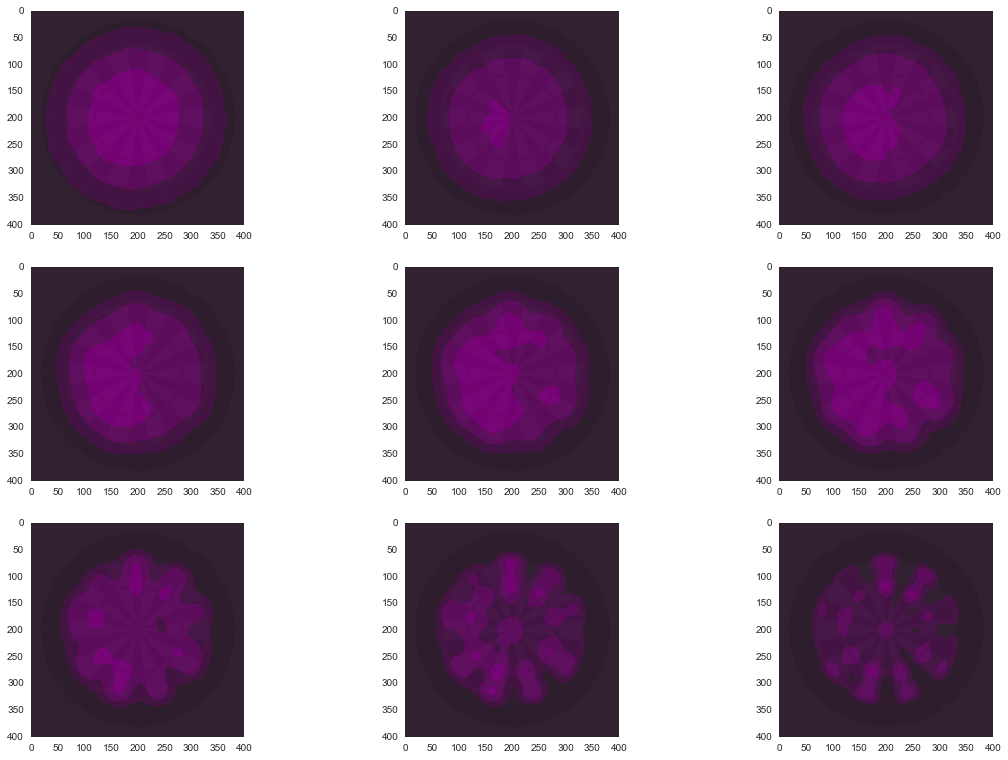

In [12]:
fig, ax = plt.subplots(pic_rows,pic_columns, figsize=(19,13))

count = 0 
for row in range(pic_rows):
    for col in range(pic_columns):
        
        # Run simulation at skill level
        score = scores[count]
        
        # Plot heat map
        xx,yy = np.meshgrid(np.arange(Dartboard.width),np.arange(Dartboard.length))
        cmap = pal = sns.dark_palette("purple", as_cmap=True)
        ax[row,col].contourf(xx,yy,score, 3, alpha=.99, cmap = cmap)
        ax[row,col].grid(False)
        ax[row,col].imshow(Dartboard.image)
        count += 1

Nice! The results show that when you are bad, it is important to throw directly at the bulls eye to best avoid missing. As you get better the aim location matters less (the best area becomes bigger) and moves towards the left. Then once you get to a standard devation of around 15, the best area shrinks again and becomes localized at high value locations.

$\\$

$\\$


$\\$


Instead of heat maps, lets see how the optimal location changes as you get better.

In [13]:
def optim_throw(scores):
    indexes = []
    for score in scores:
        index = np.where(score == max(np.concatenate(score)))
        indexes.append((np.median(index[1]),np.median(index[0])))
    return indexes

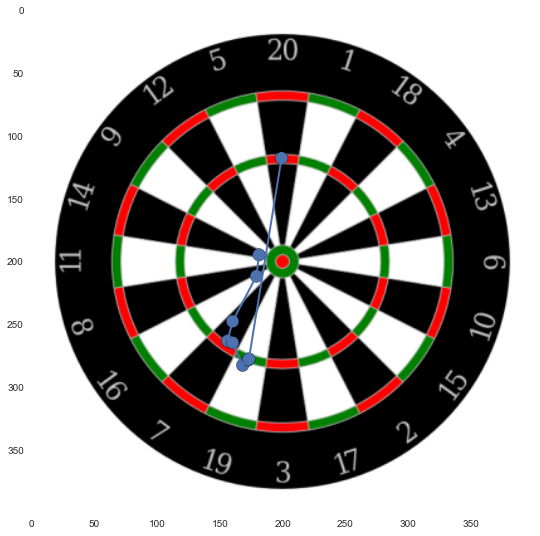

In [14]:
fig, ax = plt.subplots(figsize=(16,9))


opt_loc = optim_throw(scores)

# plot line connecting darts
x = [x[0] for x in opt_loc]
y = [y[1] for y in opt_loc]
ax.plot(x,y, lw = 2)


# plot darts
for dart in opt_loc:
    ax.add_patch(matplotlib.patches.Circle(dart, radius=5))


ax.grid(False)
ax.imshow(Dartboard.image)

If you are pretty bad, you should just aim in the middle and pray you get on board. If you are good enough to get on the board, you should aim towards the left side of the board as there is a higher concentration of high paying locations on that side. And as you get better start aiming away from the bulls eye toward the triple line and down towards 19. Then when you are super good start going for those 60s!